# Task-related articles and sentences retrieval based on two-level of tf-idf with result summary for each task.
#### Goal
Given a large number of literature and queries of interest, retrieve the most relevant information to the queries from the literature. 
#### Approach
Since there is no ground-truth answer to each task, we model each task as an information retrieval problem and adopt the tf-idf features to quantize the similarity between queries of each task and articles. Specifically, we implement a two-level tf-idf information retrieval system. On the first level, the most relevant articles are retrieved for each task. On the second level, the most relevant sentences are retrieved from the articles retrieved on the first level. The articles/sentences are ranked based on cosine similarity between tf-idf feature vectors of articles/sentences and the target query. The same approach is applicable to all 10 tasks in this challenge. Once all the articles are vectorized and indexed, they can be reloaded to quickly respond to different queries of different tasks without re-training.
#### Afterwards analyses
At the end of this notebook, we also provide a mixed short-cut for the articles and sentences we retrieved for each of the 10 tasks. This summary of results may not represent a professional or comprehensive analysis of all available COVID-19 studies so far, but may still serve as a reference that we hope may help inspire further examinations. We are submitting the same notebook to all tasks in case the reviewers of one task may also be interested to see the results for other tasks.

In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import collections
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
import time
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
import pickle
import json

# I. Metadata basic statistics
We first examine the metadata to gain a deeper understanding of the dataset. We pay more attention to the abstracts as an abstract is usually a high-level summary of the discovery of a study, thus it is information-enriched. In addition, while less than half of the articles have a full-text available, most articles have an abstract provided.

## 1. Read-in metadata

In [3]:
#metaDataPath = "/kaggle/input/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
print("The number of articles: " + str(metaData.shape[0]))
metaData.head()

The number of articles: 29500


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


## 2. Nan elements counts in all columns

In [4]:
metaData.isnull().sum()

sha                            12080
source_x                           0
title                            370
doi                             3143
pmcid                           2163
pubmed_id                      12770
license                        11808
abstract                        2947
publish_time                   11252
authors                          946
journal                        11709
Microsoft Academic Paper ID    28366
WHO #Covidence                 28264
has_full_text                  12080
dtype: int64

## 3. Literature source distribution

In [5]:
sourceDic = collections.defaultdict(int)
for s in metaData["source_x"][metaData["source_x"].notnull()]:
    sourceDic[s] += 1
sizes = []
explode = []
labels = []
for s in sourceDic:
    sizes.append(sourceDic[s])
    explode.append(0)
    labels.append(s)

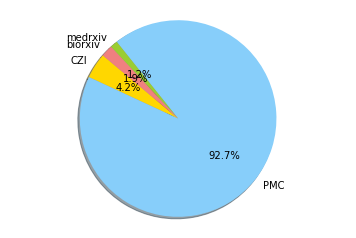

In [6]:
colors = ['gold', 'lightskyblue', 'yellowgreen', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## 4. Publish year distribution

In [7]:
yearList = []
for y in metaData["publish_time"][metaData["publish_time"].notnull()]:
    yearList.append(int(re.split(' |-', y)[0]))

Text(0, 0.5, 'Frequency')

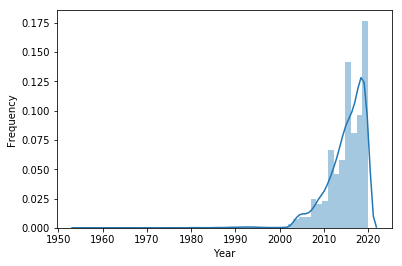

In [8]:
sns.distplot(yearList, bins = 50)
plt.xlabel("Year")
plt.ylabel("Frequency")

A lot more coronaviruses related articles published in the past 10 years.

## 5. Has full text distribution

In [9]:
hasFullText = metaData["has_full_text"][metaData["has_full_text"].notnull()]
nanCount = metaData.shape[0] - hasFullText.shape[0]
trueCount = sum(hasFullText)
falseCount = hasFullText.shape[0] - trueCount
print("The number of articles with full text: " + str(trueCount))
print("The number of articles without full text: " + str(falseCount + nanCount))

The number of articles with full text: 13219
The number of articles without full text: 16281


## 6. Abstract distribution

In [10]:
print("The number of articles with abstract: " + str(sum(metaData["abstract"].notnull())))

The number of articles with abstract: 26553


Now we try to normalize the abstracts to learn the distribution of abstract length and tokens. The following steps will also be the steps to preprocess the abstracts for extracting tf-idf features.

In [11]:
startTime = time.time()
absLength = []
word2count = {}
for abstract in metaData["abstract"][metaData["abstract"].notnull()]:
    ## Remove web links
    abstract = re.sub('https?://\S+|www\.\S+', '', abstract) 

    ## Lowercase
    abstract = abstract.lower()
    
    ## Remove punctuation
    abstract = re.sub('<.*?>+', ' ', abstract)
    abstract = re.sub('[%s]' % re.escape(string.punctuation), ' ', abstract)
    
    ## Remove number
    abstract = re.sub(r'\d+', '', abstract)
    
    ## Tokenize
    words = word_tokenize(abstract)
    
    ## Remove stop words
    nltk_stop_words = stopwords.words('english')
    words = [word for word in words if word not in nltk_stop_words]
    
    ## Stem
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    ## Lematize verbs
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    ## Record length
    absLength.append(len(words))
    
    ## Get word count
    for word in words:
        count = word2count.get(word, 0)
        word2count[word] = count + 1
print("Time spent: " + str(round((time.time() - startTime) / 60, 3)) + "min.")
print("The number of tokens: " + str(len(word2count)))

Time spent: 2.217min.
The number of tokens: 50493


### Distribution of abstract length
There are 20 extremely long abstracts. We excluded them from the histogram.

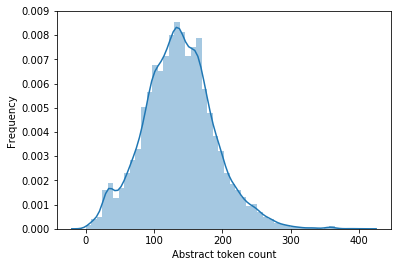

In [12]:
sns.distplot(sorted(absLength)[:-20], bins = 50) # There are 20 extremely long abstracts
plt.xlabel("Abstract token count")
plt.ylabel("Frequency")
plt.show()

### Top 50 mostly frequent tokens

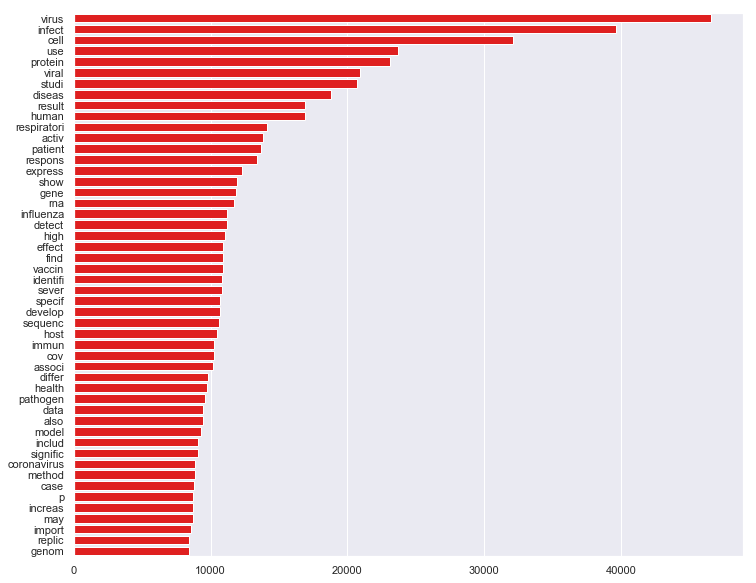

In [13]:
df_word_count = pd.DataFrame(sorted(word2count.items(), key=lambda x: x[1])[::-1])
sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(y = df_word_count[0].values[:50], x = df_word_count[1].values[:50], color='red')

# II. Article and sentence retrieval
Now let's start building the system for article and sentence retrieval. For the first level of retrieving articles, we build a tf-idf vectorizer for all articles based on their abstracts. Therefore, whether an article is considered related to a query is only based on the content in its abstract. The reasons we didn't include all text from the article is that 1. most articles don't have a full-text available; 2. abstract as a high-level summary of the discovery of the article is more information-enriched compared to the full-text; 3. only including the abstract will largely reduce the vectorizer learning time. For the second level of retrieving sentences, we first retrieving relevant articles. Then from the abstracts and paragraphs in discussion and/or conclusion sections (if exist) of the articles build a second vectorizer and retrieve the most relevant sentences. The reason we only take abstract, discussion and conclusion into consideration is that for most tasks in this challenge, the questions of interest are mostly high-level questions, to which the related information is more likely to be in summary sections rather than experiments or results sections. 

## 1. Preprocess metadata
This section only needs to be run once. The new metadata table with the normalized abstracts in the column "clean_abstract" will be saved to all_sources_metadata_2020-03-13_clean.csv in the output folder.

In [14]:
def textNormalize(rawString):
    """
    Function for text normalization.
    Text normalization includes:
    1. removing web links
    2. converting all letters to lower or upper case
    3. removing punctuations
    4. removing numbers
    5. tokenization
    6. removing stopwords
    7. stemming
    8. lemmatization
    Input:
        rawString: a string contains the text to be normaized. 
    Output:
        normText: a string contains the normalized text where the tokens extracted from rawString are joined by space.
    """
    if rawString == np.nan:
        return rawString
    ## Remove web links
    rawString = re.sub('https?://\S+|www\.\S+', '', rawString) 

    ## Lowercase
    rawString = rawString.lower()
    
    ## Remove punctuation
    rawString = re.sub('<.*?>+', ' ', rawString)
    rawString = re.sub('[%s]' % re.escape(string.punctuation), ' ', rawString)
    
    ## Remove number
    rawString = re.sub(r'\d+', '', rawString)
    
    ## Tokenize
    words = word_tokenize(rawString)
    
    ## Remove stop words
    nltk_stop_words = stopwords.words('english')
    words = [word for word in words if word not in nltk_stop_words]
    
    ## Stem
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    ## Lematize verbs
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    normText = " ".join(words)
    
    return normText

### Read-in metadata

In [16]:
#metaDataPath = "/kaggle/input/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
print("The number of articles: " + str(metaData.shape[0]))
metaData.head()

The number of articles: 29500


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


### Normalize abstracts

In [17]:
startTime = time.time()
metaData["clean_abstract"] = float("NaN")
metaData.loc[metaData["abstract"].notnull(), "clean_abstract"] = \
metaData["abstract"][metaData["abstract"].notnull()].apply(lambda x: textNormalize(x))
print("Time spent: " + str(round((time.time() - startTime) / 60, 3)) + "min.")

Time spent: 2.068min.


### Output the new metadata table

In [18]:
metaData.to_csv("~/Downloads/2020-03-13/all_sources_metadata_2020-03-13_clean.csv")

## 2. Learn tf-idf vectorizer

This section only needs to be run once. A tf-idf vectorizer will be learned from the normalized abstracts and saved to tf-idf_vectorizer.pkl in the output folder.

### Read-in metadata with normalized abstracts

In [57]:
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13_clean.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
metaData.head()

,Unnamed: 0,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,clean_abstract
0,0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True,NaN
1,1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True,NaN
2,2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True,geograph spread novel coronavirus covid infect...
3,3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True,decemb case unidentifi pneumonia histori expos...
4,4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False,NaN


### Learn vocabulary and idf from the normalized abstracts
To further constrain the searching space to focus more on coronavirus knowledge, we only include an article if either "coron" (for coronavirus) or "covid" are mentioned in its abstract. In this way, other articles that are more generally related to epidemic or other respiration diseases will be excluded. This filtering step also largely boosts learning and retrieval time. More strict rules can also be used to only include articles that are specifically related to COVID-19.

In [58]:
metaData = metaData[metaData["clean_abstract"].notnull()]
metaData = metaData[metaData["clean_abstract"].str.contains("|".join(["coron", "covid"]))]
print("The number of remaining articles: ", metaData.shape[0])

The number of remaining articles:  5246


In [59]:
startTime = time.time()
vectorizer = TfidfVectorizer(tokenizer = word_tokenize)
vectorizer.fit(metaData["clean_abstract"][metaData["clean_abstract"].notnull()])
print('Time spent: ' + str(time.time() - startTime) + 's.')

Time spent: 3.8996529579162598s.


### Save the learned vectorizer

In [60]:
vectPath = "../../../Downloads/2020-03-13/tf-idf_vectorizer.pkl"
with open(vectPath, "wb") as vectFile:
    pickle.dump(vectorizer, vectFile)

## 3. Retrieve relevant articles and sentences for each task

### Read-in metadata with normalized abstracts

In [63]:
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13_clean.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
metaData.head()

,Unnamed: 0,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,clean_abstract
0,0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True,NaN
1,1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True,NaN
2,2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True,geograph spread novel coronavirus covid infect...
3,3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True,decemb case unidentifi pneumonia histori expos...
4,4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False,NaN


In [64]:
metaData = metaData[metaData["clean_abstract"].notnull()]
metaData = metaData[metaData["clean_abstract"].str.contains("|".join(["coron", "covid"]))]

### Load the tf-idf vectorizer

In [65]:
vectPath = "../../../Downloads/2020-03-13/tf-idf_vectorizer.pkl"
with open(vectPath, 'rb') as vectFile:
    vectorizer = pickle.load(vectFile)

### Transfer abstracts to document-term matrix

In [66]:
docTermMatrix = vectorizer.transform(metaData["clean_abstract"][metaData["clean_abstract"].notnull()]).toarray()

### Queries for tasks
We allow multiple queries for each task. The top relevant articles and sentences will be retrieved for each query. Below we give the example queries we used for each task. One may choose to run any one of them as the target queries or write new queries (in the form of a list of strings). Here we show the results of running the queries for task 1. At the end of the notebook, we provide a mixed short-cut for the results we got for all tasks.

#### Task 1: What is known about transmission, incubation, and environmental stability?

In [107]:
queries = [
    "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
    "Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
    "Seasonality of transmission.",
    "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
    "Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
    "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
    "Natural history of the virus and shedding of it from an infected person",
    "Implementation of diagnostics and products to improve clinical processes",
    "Disease models, including animal models for infection, disease and transmission",
    "Tools and studies to monitor phenotypic change and potential adaptation of the virus",
    "Immune response and immunity",
    "Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
    "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
    "Role of the environment in transmission"
]

#### Task 2: What do we know about COVID-19 risk factors?

In [114]:
queries = [
    "Smoking, pre-existing pulmonary disease",
    "Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities",
    "Neonates and pregnant women",
    "Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.",
    "Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors",
    "Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups",
    "Susceptibility of populations",
    "Public health mitigation measures that could be effective for control"
]

#### Task 3: What do we know about virus genetics, origin, and evolution?

In [122]:
queries = [
    "Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.",
    "Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.",
    "Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.",
    "Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.",
    "Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.",
    "Experimental infections to test host range for this pathogen.",
    "Animal host(s) and any evidence of continued spill-over to humans",
    "Socioeconomic and behavioral risk factors for this spill-over",
    "Sustainable risk reduction strategies"
]

#### Task 4: What do we know about vaccines and therapeutics?

In [130]:
queries = [
    "Effectiveness of drugs being developed and tried to treat COVID-19 patients.",
    "Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
    "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
    "Exploration of use of best animal models and their predictive value for a human vaccine.",
    "Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
    "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
    "Efforts targeted at a universal coronavirus vaccine.",
    "Efforts to develop animal models and standardize challenge studies",
    "Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
    "Approaches to evaluate risk for enhanced disease after vaccination",
    "Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models in conjunction with therapeutics"
]

#### Task 5: What has been published about medical care?

In [138]:
queries = [
    "Resources to support skilled nursing facilities and long term care facilities.",
    "Mobilization of surge medical staff to address shortages in overwhelmed communities",
    "Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
    "Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
    "Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
    "Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
    "Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
    "Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
    "Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
    "Guidance on the simple things people can do at home to take care of sick people and manage disease.",
    "Oral medications that might potentially work.",
    "Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
    "Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
    "Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
    "Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
    "Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"
]

#### Task 6: What do we know about non-pharmaceutical interventions?

In [102]:
queries = [
    "Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
    "Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
    "Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
    "Methods to control the spread in communities, barriers to compliance and how these vary among different populations.",
    "Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
    "Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
    "Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
    "Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."
]

#### Task 7: Sample task with sample submission

In [103]:
queries = [
    "Are there geographic variations in the rate of COVID-19 spread?",
    "Are there geographic variations in the mortality rate of COVID-19?",
    "there any evidence to suggest geographic based virus mutations?"
]

#### Task 8: What do we know about diagnostics and surveillance?

In [104]:
queries = [
    "How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
    "Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
    "Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
    "National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
    "Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
    "Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
    "Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
    "Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
    "Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
    "Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
    "Policies and protocols for screening and testing.",
    "Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
    "Technology roadmap for diagnostics.",
    "Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
    "New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
    "Coupling genomics and diagnostic testing on a large scale.",
    "Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
    "Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
    "One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."
]

#### Task 9: What has been published about ethical and social science considerations?

In [105]:
queries = [
    "Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019",
    "Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
    "Efforts to support sustained education, access, and capacity building in the area of ethics",
    "Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
    "Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
    "Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
    "Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."
]

#### Task 10: What has been published about information sharing and inter-sectoral collaboration?

In [106]:
queries = [
    "Methods for coordinating data-gathering with standardized nomenclature.",
    "Sharing response information among planners, providers, and others.",
    "Understanding and mitigating barriers to information-sharing.",
    "How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
    "Integration of federal/state/local public health surveillance systems.",
    "Value of investments in baseline public health response infrastructure preparedness",
    "Modes of communicating with target high-risk populations (elderly, health care workers).",
    "Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
    "Communication that indicates potential risk of disease to all population groups.",
    "Misunderstanding around containment and mitigation.",
    "Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
    "Measures to reach marginalized and disadvantaged populations.Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
    "Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
    "Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"
]

### Transfer queries to query-term matrix

In [139]:
normQueries = [textNormalize(q) for q in queries] # Text normalization for all queries
queryTermMatrix = vectorizer.transform(normQueries).toarray()

### Level 1: retrieve top related articles based on cosine similarity between tf-idf vectors

Compute cosine similarity between each query and all abstracts.

In [140]:
startTime = time.time()
queryDocDist = 1 - cdist(queryTermMatrix, docTermMatrix, metric = 'cosine')
print("Time spent: " + str(round((time.time() - startTime), 3)) + "s.")

Time spent: 1.822s.


In [141]:
def retrieveTopLiter(queries, queryDocDist, outputPath, nDoc = 5, showResults = True):
    """
    Function to retrieve the top n literatures for each query based on cosine similarities between query tf-idf 
    representations and literature tf-idf representations. 
    Input:
        queries: a list of m strings where each string is a text normalized query.
        queryDocDist: a m x n array that gives the pairwise cosine similarity between the m queries and n literatures.
        outputPath: a string specifies the path to the output file.
        nDoc (default 5): the number of literatures to be retrieved for each query.
        showResults (default True): whether show the results in the terminal.
    Output:
        The abstract and metadata of the retrieved literatures will be written to the output file specified by
        outputPath.
    """
    outputFile = open(outputPath, "w")
    for i in range(len(queries)):
        print("Query: ", queries[i])
        print("")
        outputFile.write("Query: " + queries[i] + "\n\n")
        docCount = 1
        for idx in queryDocDist[i].argsort()[-nDoc:][::-1]:
            docMeta = metaData[metaData["abstract"].notnull()].iloc[idx]
            if showResults:
                print("#" + str(docCount) + " article")
                print("Cosine similarity: ", queryDocDist[i][idx])
                print("PMC_ID: ", docMeta["pmcid"])
                print("Title: ", docMeta["title"])
                print("Abstract: ", docMeta["abstract"])
                print("Has full text: ", docMeta["has_full_text"])
                print("")
            
            outputFile.write("#" + str(docCount) + " article\n")
            outputFile.write("Cosine similarity: " + str(round(queryDocDist[i][idx], 5)) + "\n")
            outputFile.write("PMC_ID: " + str(docMeta["pmcid"]) + "\n")
            outputFile.write("Title: " + docMeta["title"] + "\n")
            outputFile.write("Abstract: " + docMeta["abstract"] + "\n")
            outputFile.write("Has full text: " + str(docMeta["has_full_text"]) + "\n\n")
            
            docCount += 1
    outputFile.close()
    return

List out the meta information for top 5 related articles

In [142]:
nDoc = 5
outputPath = "../../../Downloads/2020-03-13/topArt.txt" 
retrieveTopLiter(queries, queryDocDist, outputPath, nDoc)

Query:  Resources to support skilled nursing facilities and long term care facilities.

#1 article
Cosine similarity:  0.2723194826605144
PMC_ID:  PMC6154147
Title:  Severe Respiratory Illness Outbreak Associated with Human Coronavirus NL63 in a Long-Term Care Facility
Abstract:  We describe an outbreak of severe respiratory illness associated with human coronavirus NL63 in a long-term care facility in Louisiana in November 2017. Six of 20 case-patients were hospitalized with pneumonia, and 3 of 20 died. Clinicians should consider human coronavirus NL63 for patients in similar settings with respiratory disease.
Has full text:  True

#2 article
Cosine similarity:  0.2683122465516524
PMC_ID:  PMC2870246
Title:  Human coronavirus OC43 causes influenza-like illness in residents and staff of aged-care facilities in Melbourne, Australia.
Abstract:  Three outbreaks of respiratory illness associated with human coronavirus HCoV-OC43 infection occurred in geographically unrelated aged-care facil

Title:  Update: Public Health Response to the Coronavirus Disease 2019 Outbreak — United States, February 24, 2020 | MMWR
Abstract:  Fourteen cases have been diagnosed in the United States, in addition to 39 cases among repatriated persons from high-risk settings, for a current total of 53 cases within the United States. U.S. government agencies and public health partners are implementing aggressive measures to slow and try to contain transmission of COVID-19 in the United States.
Has full text:  nan

#3 article
Cosine similarity:  0.1140373939216145
PMC_ID:  nan
Title:  Initial Public Health Response and Interim Clinical Guidance for the 2019 Novel Coronavirus Outbreak - United States, December 31, 2019-February 4, 2020
Abstract:  On December 31, 2019, Chinese health officials reported a cluster of cases of acute respiratory illness in persons associated with the Hunan seafood and animal market in the city of Wuhan, Hubei Province, in central China. On January 7, 2020, Chinese health 

We can see that most retrieved articles are highly correlated with the queries, especially for longer queries that provide a more detailed description of the information need. We also noticed that there are repeats articles in the dataset, probably due to the submission of the same article to multiple pre-print or print platforms.

### Level 2: retrieve top related sentences based on cosine similarity between tf-idf vectors

Now for each retrieved article, check if a full text is available. When a full text is available, the abstracts and all paragraphs in discussion and conclusion sections (if exists) are used for sentence retrieval. When a full text is not available, only the abstract is used. All these contents are then segmented into sentences and combined for retrieving the top n related sentences for a query. The motivation behind retrieving sentences is that we are expecting the most relevant sentences may help compose a summary paragraph for each query.

In [143]:
def findFile(name, path):
    """
    Function to locate a file in a directory.
    Input:
        name: a string gives the name of the target file.
        path: a string gives the directory to search the file.
    Output:
        return the path of the target file if the file is found. Otherwise return None.
    """
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
    return None

In [144]:
def retrieveTopSent(queries, queryDocDist, dataPath, outputPath, nDoc = 5, nSent = 10, showResults = True):
    """
    Function to retrieve the top n sentences for each query based on cosine similarities between query tf-idf 
    representations and sentence tf-idf representations.
    The retrieval is done by steps:
        1. retrive the top nDoc literatures related to each query.
        2. from the top nDoc literatures retrieve the top nSent sentences related to each query.
    Input:
        queries: a list of m strings where each string is a text normalized query.
        queryDocDist: a m x n array that gives the pairwise cosine similarity between the m queries and n literatures.
        dataPath: a string specifies the path to the full-text files.
        outputPath: a string specifies the path to the output file.
        nDoc (default 5): the number of literatures to be retrieved for each query.
        nSent (default 10): the number of sentences to be retrieved for eacu query.
        showResults (default True): whether show the results in the terminal.
    """
    outputFile = open(outputPath, "w")
    for i in range(len(queries)):
        query = queries[i]
        print("Query: ", query)
        print("")
        outputFile.write("Query: " + queries[i] + "\n\n")
        querySents = []
        sentPmcid = []
        for idx in queryDocDist[i].argsort()[-nDoc:][::-1]:
            docMeta = metaData[metaData["abstract"].notnull()].iloc[idx]
            docRepText = docMeta["abstract"] # Include abstract to represent a literature
            pmcid = docMeta["pmcid"]
            if docMeta["has_full_text"] == True: # Has full text
                sha = docMeta["sha"]
                jsonFile = findFile(sha + ".json", dataPath) # Retrieve the full text with sha
                if jsonFile:
                    with open(jsonFile) as f:
                        doc = json.load(f)
                    for para in doc["body_text"]:
                        if para["section"].lower() in ["discussion", "conclusion"]: 
                            docRepText = docRepText + " " + para["text"] # Include paragraphs in discussion and conclusion
            docRepSents = sent_tokenize(docRepText) # Sentence segmentation
            querySents = querySents + docRepSents # Add sentences of this literature to all sentences related to the query
            sentPmcid = sentPmcid + [pmcid] * len(docRepSents)
        normQuerySents = [textNormalize(sent) for sent in querySents] # Text normalization for all sentences
        qVectorizer = TfidfVectorizer(tokenizer = word_tokenize) # Learn a vectorizer for retrieiving sentences
        qVectorizer.fit(normQuerySents)
        print("Vocabulary size: ", len(qVectorizer.get_feature_names()))
        print("")
        sentTermMatrix = qVectorizer.transform(normQuerySents).toarray() # Transfer sentences to sentence-term matrix
        queryTermMatrix = qVectorizer.transform([textNormalize(query)]).toarray() # Transfer the query to query-term matrix
        querySentDist = 1 - cdist(queryTermMatrix, sentTermMatrix, metric = 'cosine') # Compute cosine similarity
        sentCount = 1
        for iidx in querySentDist[0].argsort()[-nSent:][::-1]: # Show the top n related sentences
            if np.isnan(querySentDist[0][iidx]):
                continue
            if showResults:
                print("#" + str(sentCount) + " sentence")
                print("Cosine similarity: ", querySentDist[0][iidx])
                print("PMC_ID: ", sentPmcid[iidx])
                print(querySents[iidx])
                print("")
            outputFile.write("#" + str(sentCount) + " sentence\n")
            outputFile.write("Cosine similarity: " + str(round(querySentDist[0][iidx], 5)) + "\n")
            outputFile.write("PMC_ID: " + str(sentPmcid[iidx]) + "\n")
            outputFile.write(querySents[iidx] + "\n\n")
            sentCount += 1
    outputFile.close()
    return

In [145]:
nDoc = 5
nSent = 10
dataPath = "../../../Downloads/2020-03-13"
outputPath = "../../../Downloads/2020-03-13/topSent.txt" 
retrieveTopSent(queries, queryDocDist, dataPath, outputPath, nDoc, nSent)

Query:  Resources to support skilled nursing facilities and long term care facilities.

Vocabulary size:  204

#1 sentence
Cosine similarity:  0.4277623335395082
PMC_ID:  PMC6154147
We describe an outbreak of severe respiratory illness associated with human coronavirus NL63 in a long-term care facility in Louisiana in November 2017.

#2 sentence
Cosine similarity:  0.21762101621888608
PMC_ID:  nan
While ensuring the completion of treatment work, we manage to leverage nursing human resources in a scientific, standardized and maximized efficiency manner, to ensure the quality of nursing, and the physical and mental health of nursing staff.

#3 sentence
Cosine similarity:  0.21393483063924768
PMC_ID:  PMC4630490
Ninety-seven percent (181/186) of the cases had exposure to the health care facilities.

#4 sentence
Cosine similarity:  0.17134737594010996
PMC_ID:  nan
The future resilience of healthcare services will depend on having sufficient numbers of nurses who are adequately resourced to

Vocabulary size:  650

#1 sentence
Cosine similarity:  0.3501958230554416
PMC_ID:  nan
Many severe hypoxemic patients only receive high-flow nasal oxygen (HFNO) or noninvasive mechanical ventilation rather than invasive mechanical ventilation because of intubation delay or lack of mechanical ventilators (especially at early phase).

#2 sentence
Cosine similarity:  0.31533090925940754
PMC_ID:  nan
Our preliminary data show that only about 25% of patients who died were intubated and received mechanical ventilation.JO - Intensive Care Medicine

#3 sentence
Cosine similarity:  0.24743381145789278
PMC_ID:  nan
29 (56%) of 52 patients were given non-invasive ventilation at ICU admission, of whom 22 (76%) required further orotracheal intubation and invasive mechanical ventilation.

#4 sentence
Cosine similarity:  0.20121731154011047
PMC_ID:  PMC3999990
Likewise, advanced age correlated with more adverse disease outcomes following severe acute respiratory syndrome coronavirus (SARS-CoV) infect

Vocabulary size:  457

#1 sentence
Cosine similarity:  0.2256151749143892
PMC_ID:  nan
As more is learned about this novel virus and this outbreak, CDC will rapidly incorporate new knowledge into guidance for action by CDC and state and local health departments.

#2 sentence
Cosine similarity:  0.22485013118264485
PMC_ID:  nan
Fourteen cases have been diagnosed in the United States, in addition to 39 cases among repatriated persons from high-risk settings, for a current total of 53 cases within the United States.

#3 sentence
Cosine similarity:  0.2197918278700789
PMC_ID:  nan
Fourteen cases have been diagnosed in the United States, and an additional 39 cases have occurred among repatriated persons from high-risk settings, for a current total of 53 cases within the United States.

#4 sentence
Cosine similarity:  0.1968208211874105
PMC_ID:  nan
As more is learned about this novel virus and this outbreak, CDC will rapidly incorporate new knowledge into guidance for action by CDC, state a

Vocabulary size:  483

#1 sentence
Cosine similarity:  0.17093310684088014
PMC_ID:  PMC4622256
We evaluated whether cycle threshold (C(t)) values (which are inversely related to virus load) were associated with clinical severity in patients from Saudi Arabia whose nasopharyngeal specimens tested positive for this virus by real-time reverse transcription PCR.

#2 sentence
Cosine similarity:  0.1640021311986225
PMC_ID:  PMC5454172
Because of the lack of such intervention strategies, supportive care is the best that can be offered at the moment.

#3 sentence
Cosine similarity:  0.16147992192949223
PMC_ID:  PMC4622256
We showed that several other risk factors were associated with death and severe outcome on multivariable analysis.

#4 sentence
Cosine similarity:  0.1607042741491207
PMC_ID:  PMC4622256
At this time, MERS-CoV has no known treatment, other than supportive care.

#5 sentence
Cosine similarity:  0.15484145443564223
PMC_ID:  PMC4622256
Our findings did not change when we adjuste

Vocabulary size:  521

#1 sentence
Cosine similarity:  0.1880222847727937
PMC_ID:  nan
Some patients required supplemental oxygen and had variable clinical outcomes following treatment with an antiretroviral agent.

#2 sentence
Cosine similarity:  0.18460622155568007
PMC_ID:  PMC3016795
Advanced age, high admission neutrophil count, and high initial lactate dehydrogenase level were independent correlates of an adverse clinical outcome.

#3 sentence
Cosine similarity:  0.16745303078738627
PMC_ID:  PMC3016795
The viral load could be a determinant of these prognostic association factors.

#4 sentence
Cosine similarity:  0.1548276968614941
PMC_ID:  nan
Clinical course was summarized, including requirement for supplemental oxygen and intensive care and use of empirical treatment with lopinavir-ritonavir.Among the 18 hospitalized patients with PCR-confirmed SARS-CoV-2 infection (median age, 47 years; 9 [50%] women), clinical presentation was an upper respiratory tract infection in 12 (67%), 

Compared to the article retrieved based on abstracts, some of the sentences retrieved here are more specifically related to the query while others only contain part of the information, which may need complement from its context.

# III. Results summary for each task

Below we provide a mixed short-cut of selected content from articles and sentences we retrieved for the queries of each task. We have been very cautious to not overextend any conclusions or observations reported in the original articles, and only add minimal modifications to make some sentences more readable. We also provide pmcid as the reference to the article that supports each statement wherever available. The summary was written based on the articles included in the dataset, which may no longer reflect the most up-to-date research progress in this active field.

#### Task 1: What is known about transmission, incubation, and environmental stability?
Controversy remains about whether COVID-19 has infectivity during the incubation period. A case was reported that did not show infectivity during the incubation period. Another clustering outbreak case suggested asymptomatic patients may be the key point to control the epidemic. A shorter incubation period of SARS-CoV may associate with more severe disease (PMC_ID: PMC4889459). A longer incubation period of MERS-CoV may associate with a lower risk of death (PMC_ID: PMC4766874). Longer recovery delay of MERS-CoV was seen in patients of older age, ICU admission, and abnormal radiology findings (PMC_ID: PMC6086845). Before 2012, CoV infection was found not associated with hospitalization or with increased severity of illness for children hospitalized for acute respiratory illness and/or fever (PMC_ID: PMC3288315). COVID-19 are usually mild in children while prolonged virus shedding is observed in the respiratory tract and feces at the convalescent stage. Before COVID-19, CoV generally displayed in winter seasonality between December and April, except HCoV-229E (PMC_ID: PMC2916580). Viruses other than influenza may also be important contributors to hospitalization and mortality during the peak weeks of influenza seasons, especially for the elderly (PMC_ID: PMC4281811). The role of camels in the transmission of MERS-CoV has been confirmed (PMC_ID: PMC6518552, PMC_ID: PMC6518552). Hospital-associated transmission may have a larger role than direct contact with an infected camel in the spread of MERS-CoV (PMC_ID: PMC6518552). Studies have described the ability of CoVs to survive in different environmental conditions (e.g. temperature and humidity), on different supports found in hospital settings such as aluminum, sterile sponges or latex surgical gloves or in biological fluids (PMC_ID: PMC3509683). Nasal discharge showed a higher viral positivity than feces for bovine CoV, which seemed to be associated with positive detection in the plasma (PMC_ID: PMC6068295). In an evaluation of clinical specimens from SARS patients, 34 (52%) of 66 nasopharyngeal aspirate samples from 50 patients, 5 (5%) of 94 urine samples from 94 patients, and 36 (55%) of 65 fecal samples from 65 patients tested positive for SARS CoV nucleocapsid protein (PMC_ID: PMC446266). Pathogenic CoV-229E remained infectious in a human lung cell culture model following at least 5 days of persistence on a range of common nonbiocidal surface materials, including polytetrafluoroethylene (Teflon; PTFE), polyvinyl chloride (PVC), ceramic tiles, glass, silicone rubber, and stainless steel (PMC_ID: PMC4659470). CoV-229E was rapidly inactivated on a range of copper alloys (within a few minutes for simulated fingertip contamination) and Cu/Zn brasses were very effective at lower copper concentration. Exposure to copper destroyed the viral genomes and irreversibly affected virus morphology, including disintegration of envelope and dispersal of surface spikes (PMC_ID: PMC4659470). Most viruses from the respiratory tract, including SARS, can persist on surfaces for a few days (PMC_ID: PMC1564025). The analysis of 22 studies reveals that human coronaviruses such as SARS-CoV, MERS-CoV or endemic human coronaviruses (HCoV) can persist on inanimate surfaces like metal, glass or plastic for up to 9 days, but can be efficiently inactivated by surface disinfection procedures with 62–71% ethanol, 0.5% hydrogen peroxide or 0.1% sodium hypochlorite within 1 minute. Alpacas may be suitable models for infection and shedding dynamics of MERS-CoV (PMC_ID: PMC4880109). Rhesus macaque and common marmoset have been established as animal models for MERS-CoV (PMC_ID: PMC4140844). A current limitation of animal models for CoV is that no animal model perfectly recapitulates the disease seen in humans (PMC_ID: PMC4811657). No evidence was found of changes in the evolutionary rate of MERS-CoV and no reason to suspect adaptive changes in viral proteins (PMC_ID: PMC4734539). Many, if not all, viruses, including CoV, suppress innate immune responses to gain a window of opportunity for efficient virus replication and setting-up of the infection (PMC_ID: PMC6959104). Potential targets have been identified for immune responses to COVID-19 and provide essential information for understanding human immune responses to this virus and evaluation of diagnostic and vaccine candidates. For SARS-CoV, the humoral immune response was enhanced most effectively through the use of inactivated virus with adjuvants, either MF59 or alum, and was associated with stimulation of the CD4 but not the CD8 response (PMC_ID: PMC1280202). MERS-CoV and SARS-CoV have evolved diverse strategies to evade and block host immune responses, facilitating infection and transmission (PMC_ID: PMC4821769).  Full precautions should be applied and carefully followed to prevent the transmission of MERS-CoV, especially among health care workers (PMC_ID: PMC6695009). For SARS-CoV, a study reported that there was no evidence of transmission of infection before symptom onset (PMC_ID: PMC2870589). The patients treated in the burn and wound care ward are susceptible to viral infection because of disease, age and other factors, so it is very important to manage the burn and wound care ward during the prevention and control of CoV epidemic. Extensive measures to reduce person-to-person transmission of COVID-19 have been implemented to control the current outbreak. Special attention and efforts to protect or reduce transmission should be applied in susceptible populations including children, health care providers, and elderly people. Contaminated surfaces may play a major role in transmission of SARS-CoV in the hospital and the community (PMC_ID: PMC3265313). The better stability of SARS-CoV at low temperature and low humidity environment may facilitate its transmission in community in subtropical area (such as Hong Kong) during the spring and in air-conditioned environments (PMC_ID: PMC3265313). In countries such as Singapore and Hong Kong where there is an intensive use of air-conditioning, transmission of SARS-CoV largely occurred in well-air-conditioned environments such as hospitals or hotels (PMC_ID: PMC3265313).

#### Task 2: What do we know about COVID-19 risk factors?
Evidence of an impact of legislative bans on smoking prevalence and tobacco consumption is inconsistent, with some studies not detecting additional long‐term change in existing trends in smoking prevalence or impact on respiratory and perinatal health outcomes (PMC_ID: PMC6486282). Coronavirus infection should be considered in differential diagnosis of respiratory tract illness in adults including those that require hospitalization, have a history of smoking and have pulmonary comorbidities (PMC_ID: PMC5631947). Pulmonary function testing procedures have been associated with an increasing risk of COVID-19 transmission among patients/subjects and medical staffs. It is strongly recommended to suspend the pulmonary function test for the confirmed or suspected cases of COVID-19 during the contagious stage, and to postpone the test for other patients if it is not imperative. H1N1 patients coinfected with rhinovirus had less severe disease while non-rhinovirus co-infections were associated with substantially higher severity without changes in influenza viral titer (PMC_ID: PMC3153592). There was a significant decrease in the duration of influenza A viral shedding in co-infections (of any respiratory viruses) compared to single infections (PMC_ID: PMC6625191). Respiratory viruses rarely reach their epidemic peak concurrently and there appears to be a negative association between infection with one respiratory virus and co-infection with another (PMC_ID: PMC6625191). Co-detections of specific clusters of viruses were observed in 9% of acute respiratory illness cases particularly in children, were less frequent in households without children, and were less symptomatic (e.g., lower fever) than single infections (PMC_ID: PMC4344779). Most frequently co-detected viruses were coronavirus, respiratory syncytial virus, and influenza A virus (PMC_ID: PMC4344779). Co-infection was less likely with increasing age, which may be a consequence of pre-existing immunity or decreased viral shedding with increasing age (PMC_ID: PMC6625191). Infection by rhinovirus may result in temporary immunity of the host to infection by other respiratory viruses due to the production of cytokines, thus resulting in a negative association between rhinovirus infection and co-infection with another virus (PMC_ID: PMC6625191). So far, no maternal deaths have been reported for women with COVID-19. There appears to be some risk of premature rupture of membranes, preterm delivery, fetal tachycardia and fetal distress when the infection occurs in the third trimester of pregnancy. There is no evidence suggesting transplacental transmission based on very limited data, as the analysis of amniotic fluid, cord blood, neonatal throat swab, and breast milk samples available from six of the nine patients were found to be negative for COVID-19. Whether virus shedding occurs vaginally is also not known. In general, the clinical characteristics of the pregnant women with COVID-19 pneumonia were similar to those of non-pregnant adult patients who developed COVID-19 pneumonia. Another study reported that the impact of COVID-19 infection on pregnant women appears to be less severe. Both SARS coronavirus and H7N9 viruses presented a global epidemic threat, but the social and economic impacts of H7N9 were not as serious as in the case of SARS because the response to H7N9 was more effective (PMC_ID: PMC6046118). A mathematical model for MERS-CoV transmission dynamics has been used to estimate the transmission rates in two periods due to the implementation of intensive interventions (PMC_ID: PMC4776270). The serial interval of COVID-19 is close to or shorter than its median incubation period. This suggests that a substantial proportion of secondary transmission may occur prior to illness onset. The COVID-19 serial interval is also shorter than the serial interval of severe acute respiratory syndrome (SARS), indicating that calculations made using the SARS serial interval may introduce bias. Among patients infected with a respiratory virus, risk of hospitalization was higher among underweight adult patients, and obese patients had a longer mean length of stay once hospitalized (PMC_ID: PMC6809817). Underweight children were not at increased risk of hospitalization (PMC_ID: PMC6809817). For MERS-CoV, increased age and underlying comorbidity were risk factors for both death and severe disease, while cases arising in Saudi Arabia were more likely to be severe (PMC_ID: PMC5023790). There is no significant association between alleles or genotypes of the MASP2 tagSNP and susceptibility to SARS-CoV in both Beijing and Guangzhou populations (PMC_ID: PMC2683852). MASP2 polymorphisms is not directly related to SARS-CoV susceptibility in northern and southern Chinese (PMC_ID: PMC2683852). Strong infection control and response measures were effective in controlling the outbreak of MERS-CoV in the Republic of Korea (PMC_ID: PMC4957609). Two of the most effective policy procedures to prevent infections of SARS-CoV would be to apply stringent precautionary measures and to impose quicker and more effective quarantine of the exposed populace (PMC_ID: PMC1732706).

#### Task 3: What do we know about virus genetics, origin, and evolution?
A web-based tool (SummaryGenome Detective) was developed to allow tracking of new viral mutations as the outbreak expands globally, which may help to accelerate the development of novel diagnostics, drugs and vaccines to stop the COVID-19 disease. A web-based portal (WashU Virus Genome Browser) was developed for viewing virus genomic data, which is home to 16 complete 2019-nCoV genome sequences, together with hundreds of related viral sequences including SARS-CoV, MERS-CoV, and Ebola virus. Genetic and epidemiological evidence indicate camels serve as a reservoir for MERS virus (PMC_ID: PMC4720378). The emergence of MERS-CoV was believed to be of zoonotic origin from bats with dromedary camels as intermediate hosts. There is a likelihood of other domestic livestock serving as intermediate hosts for this virus (PMC_ID: PMC6473935). RNA-RNA recombination may play a significant role in natural evolution and neuropathogenesis of coronaviruses (PMC_ID: PMC253235). It is unclear whether higher virus load causally leads to severe outcomes of MERS-CoV (PMC_ID: PMC4622256). Wildlife trade can facilitate zoonotic disease transmission and represents a threat to human health and economies in Asia, highlighted by the 2003 SARS coronavirus outbreak, where a Chinese wildlife market facilitated pathogen transmission (PMC_ID: PMC4805265). Highly pathogenic viruses elicit expression of many of the same key genes as lower pathogenic viruses but to a higher degree. This increased degree of expression may result in the uncontrolled co-localization of inflammatory cell types and lead to irreversible host damage (PMC_ID: PMC3297540). In addition to SARS, the highly pathogenic avian influenza virus (AIV), H5N1, and the lower pathogenicity H9N2 AIV have expanded their host ranges to infect human beings and other mammalian species as well as birds (PMC_ID: PMC2865088). Viruses that originate in bats may be the most notorious emerging zoonoses that spill over from wildlife into domestic animals and humans (PMC_ID: PMC4262174). Transmission of viruses from bats to humans requires a hierarchy of enabling conditions that connect the distribution of reservoir hosts, viral infection within these hosts, and exposure and susceptibility of recipient hosts (PMC_ID: PMC4262174). The advancements in metagenomic techniques have allowed the identification of SARS-like coronaviruses (SL-CoVs) sequences that share high homology to the human SARS-CoV epidemic strains from wildlife bats, presenting concrete evidence that bats are the origin and natural reservoir of SARS-CoV (PMC_ID: PMC5287300). Demographic factors, such as race, smoking status, and socioeconomic status, may confer an increased risk of susceptibility to viruses including CoV (PMC_ID: PMC2593164).

#### Task 4: What do we know about vaccines and therapeutics?
Drugs developed for HIV and Ebola are being tested for treating COVID-19. In the epidemic of COVID-19, front-line medical staff in emergency traumatic orthopedics is faced with great challenges in the process of diagnosing and treating patients. Lung computed tomography images are being used for supporting the diagnosis of COVID-19. It is considered particularly important for medical institutions of all levels to maintain safe and effective routine services while doing well in COVID-19 prevention. Viral protease inhibitors are remarkably effective at blocking the replication of viruses such as human immunodeficiency virus and hepatitis C virus, but they inevitably lead to the selection of inhibitor-resistant mutants, which may contribute to ongoing disease (PMC_ID: PMC4178758). To date, effective treatment is lacking; however, clinical trials investigating the efficacy of several agents, including remdesivir and chloroquine, are underway in China for COVID-19. From the Chinese Clinical Trial Registry (http://www.chictr.org.cn) and U.S. National Library of Medicine Clinical Trial Registry (https://clinicaltrials. gov), there are 125 clinical trials registered by February 18, 2020, focusing on the treatment of COVID-19. There is an upward trend on the number of registered clinical trials. Among the 125 clinical trials on treatment, 33.3% used anti-viral agents, 14.7% anti-inflammation or immunomodulators, 33.3% herbs or traditional Chinese medicine (TCM), 9.3% cell-based therapy, 2.3% antioxidation and 7.0% other approaches. Studies suggest that the human receptor for COVID-19 may be angiotensin-converting enzyme 2 (ACE2) receptor similar to that of SARS-CoV. The nucleocapsid (N) protein of COVID-19 has nearly 90% amino acid sequence identity with SARS-CoV. The N protein antibodies of SARS-CoV may cross react with COVID-19 but may not provide cross-immunity. Antibody-dependent enhancement (ADE) of viral entry has been a major concern for epidemiology, vaccine development, and antibody-based drug therapy. The discrepancy between the severity of cases observed in the Hubei province of China and those occurring elsewhere in the world may due to the antibody dependent enhancement (ADE) of SARS-CoV-2 due to prior exposure to other coronaviruses. Antibody-dependent enhancement (ADE), a phenomenon in which viral replication is increased rather than decreased by immune sera, has been observed in vitro for a large number of viruses of public health importance, including flaviviruses, coronaviruses, and retroviruses (PMC_ID: PMC1257724). Vaccination is a major strategy for containing resurgence of SARS in humans, and a number of vaccine candidates have been tested in experimental animal models (PMC_ID: PMC3187504). In general, the potential vaccine candidates for MERS-CoV can be classified into six types: viral vector-based vaccine, DNA vaccine, subunit vaccine, nanoparticle-based vaccine, inactivated-whole virus vaccine and live-attenuated vaccine (PMC_ID: PMC6688523). Animal models are utilized to gain insight into the pathogenesis of disease with the overall goal of identifying potential targets for intervention and evaluating specific therapeutics and vaccines (PMC_ID: PMC3644300). MERS-CoV has been used to screen FDA-approved drugs identify potential therapeutic options for treatment of MERS-CoV infections and provide a basis for potential therapeutic options for COVID-19. COVID-19 imaging characteristic mainly has subpleural, centrilobular and diffused distribution. N protein can be used as an early diagnostic maker for SARS (PMC_ID: PMC3329003). Several types of vaccines have been developed for SARS-CoV including inactivated viruses, subunit vaccines, virus-like particles (VLPs), DNA vaccines, heterologous expression systems, and vaccines derived from SARS-CoV genome by reverse genetics (PMC_ID: PMC2633062). Transgenic mouse model has been developed for MERS-CoV (PMC_ID: PMC4403411). The standard small animals, mice, hamsters, and ferrets, all lack the functional MERS-CoV receptor and are not susceptible to infection (PMC_ID: PMC4403411). Camel vaccination for MERS-CoV may be a novel approach to preventing the human infection (PMC_ID: PMC4969153). For SARS-CoV, evaluations of an inactivated whole virus vaccine in ferrets and nonhuman primates and a virus-like-particle vaccine in mice induced protection against infection but challenged animals exhibited an immunopathologic-type lung disease (PMC_ID: PMC3335060). The majority of MERS vaccines under development are based on MERS-CoV S protein, including full-length S, S1, and receptor-binding domain (RBD). (PMC_ID: PMC6355461).

#### Task 5: What has been published about medical care?
While ensuring the completion of treatment work of COVID-19, Beijing You'an Hospital manage to leverage nursing human resources in a scientific, standardized and maximized efficiency manner, to ensure the quality of nursing, and the physical and mental health of nursing staff. The future resilience of healthcare services will depend on having sufficient numbers of nurses who are adequately resourced to face the coming challenges such as the new coronavirus COVID-19. Ninety-seven percent (181/186) of the MERS-CoV cases in Korea had exposure to the health care facilities (PMC_ID: PMC4630490). Three outbreaks of HCoV-OC43 in Melbourne establish this virus as a cause of morbidity in aged-care facilities and add to increasing evidence of the significance of coronavirus infections (PMC_ID: PMC2870246). All healthcare facilities should establish and implement infection prevention and control measure as well as triage policies and procedures for early detection and isolation of suspected MERS-CoV cases (PMC_ID: PMC4630490). In COVID-19 epidemic, the incidence of anxiety and stress disorder is high among medical staff. Medical institutions should strengthen the training of psychological skills of medical staff. Special attention should be paid to the mental health of female nurses. In hospitals there is above average risk for exposure to infectious diseases (PMC_ID: PMC4405869). The following baseline factors were independently associated with worse survival of SARS-CoV: older age (61–80 years), presence of an active comorbid condition and higher initial viral load of SARS coronavirus (PMC_ID: PMC527336). For MERS-CoV, hospital mortality was 25%; septic shock/organ failure at admittance was a significant predictor of mortality ().

#### Task 6: What do we know about non-pharmaceutical interventions?

#### Task 7: Sample task with sample submission

#### Task 8: What do we know about diagnostics and surveillance?

#### Task 9: What has been published about ethical and social science considerations?

#### Task 10: What has been published about information sharing and inter-sectoral collaboration?